# WOFOST History Matching

This tutorial will cover the use of history matching on the WOFOST simulation model.

We can think of black-box optimisation as iteratively exploring the input space of WOFOST to find a best solution (in the case of single-objective optimisation) or a set of best solutions (for multi-objective optimisation), without needing access to or derivatives of the internal equations.

By contrast, history matching is used to systematically rule out regions of the model's input space that are inconsistent with observed fruit LAI data. Instead of seeking a single "best-fit" parameter set, it identifies the ensemble of plausible parameter combinations that produce model outputs in agreement with observed LAI measurements, accounting for observational uncertainty and model structural limitations. 

Iteratively, implausible regions of parameter space are excluded, narrowing down to a set of non-implausible parameter combinations that inform model calibration. [More information on history matching can be found here](https://mogp-emulator.readthedocs.io/en/latest/methods/thread/ThreadGenericHistoryMatching.html).

# Imports

We will first import all required dependencies.

In [1]:
import pandas as pd
import numpy as np
import yaml
import os.path as osp
import copy

from calisim.data_model import (
	DistributionModel,
	ParameterDataType,
	ParameterSpecification,
)

from calisim.history_matching import (
	HistoryMatchingMethod,
	HistoryMatchingMethodModel,
)

import pcse
from pcse.models import Wofost72_PP
from pcse.base import ParameterProvider
from pcse.input import NASAPowerWeatherDataProvider, YAMLAgroManagementReader, YAMLCropDataProvider, WOFOST72SiteDataProvider, DummySoilDataProvider

# Observed data

We will next load the observed field data.

Climate data will be from the Netherlands (latitude=52, longitude=5).

We will set WAV (initial amount of available soil moisture in excess of the wilting point) to 50.

We will use dummy soil data.

In [2]:
wdp = NASAPowerWeatherDataProvider(latitude=52, longitude=5)
print(wdp)

Weather data provided by: NASAPowerWeatherDataProvider
--------Description---------
NASA/POWER Source Native Resolution Daily Data
----Site characteristics----
Elevation:    3.5
Latitude:  52.000
Longitude:  5.000
Data available for 1984-01-01 - 2025-10-21
Number of missing days: 0



In [3]:
sited = WOFOST72SiteDataProvider(WAV=50)
print(sited)

{'IFUNRN': 0, 'NOTINF': 0, 'SSI': 0.0, 'SSMAX': 0.0, 'WAV': 50.0, 'SMLIM': 0.4}


In [4]:
soild = DummySoilDataProvider()
print(soild)

{'SMFCF': 0.3, 'SM0': 0.4, 'SMW': 0.1, 'RDMSOL': 120, 'CRAIRC': 0.06, 'K0': 10.0, 'SOPE': 10.0, 'KSUB': 10.0}


In [5]:
cropd = YAMLCropDataProvider(fpath="data", force_reload=True)
print(cropd)

Crop parameters loaded from: /mnt/c/Users/james/projects/calisim-examples/workshop/6_wofost/data
Crop and variety not set: no active crop parameter set!



In [6]:
agro = YAMLAgroManagementReader(osp.join("data", "AGMT_C2_2020.agro"))
print(agro)

!!python/object/new:pcse.input.yaml_agro_loader.YAMLAgroManagementReader
listitems:
- 2020-04-20:
    CropCalendar:
      crop_end_date: 2020-11-03
      crop_end_type: maturity
      crop_name: potato
      crop_start_date: 2020-04-20
      crop_start_type: sowing
      max_duration: 300
      variety_name: Potato_C2_C5
    StateEvents: null
    TimedEvents: null



In [7]:
params = ParameterProvider(cropdata=cropd, sitedata=sited, soildata=soild)
wofost = Wofost72_PP(params, wdp, agro)
wofost.run_till_terminate()
observed_data = pd.DataFrame(wofost.get_output())
observed_data

,day,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,WWLOW
0,2020-04-20,-0.100000,0.120000,60.00000,0.000000,48.000000,12.000000,15.000000,0.000000,10.0,0.3,None
1,2020-04-21,-0.097173,0.120000,60.00000,0.000000,48.000000,12.000000,15.000000,0.000000,10.0,0.3,None
2,2020-04-22,-0.093882,0.120000,60.00000,0.000000,48.000000,12.000000,15.000000,0.000000,10.0,0.3,None
3,2020-04-23,-0.090047,0.120000,60.00000,0.000000,48.000000,12.000000,15.000000,0.000000,10.0,0.3,None
4,2020-04-24,-0.085667,0.120000,60.00000,0.000000,48.000000,12.000000,15.000000,0.000000,10.0,0.3,None
...,...,...,...,...,...,...,...,...,...,...,...,...
140,2020-09-07,1.963323,0.876336,16447.03535,11629.712391,3077.106707,1740.216253,1135.030442,0.128282,50.0,0.3,None
141,2020-09-08,1.972529,0.876336,16447.03535,11629.712391,3077.106707,1740.216253,1135.030442,0.088088,50.0,0.3,None
142,2020-09-09,1.982916,0.716347,16447.03535,11629.712391,3077.106707,1740.216253,1135.030442,0.085369,50.0,0.3,None
143,2020-09-10,1.992974,0.581502,16447.03535,11629.712391,3077.106707,1740.216253,1135.030442,0.071436,50.0,0.3,None


<Axes: xlabel='day', ylabel='LAI'>

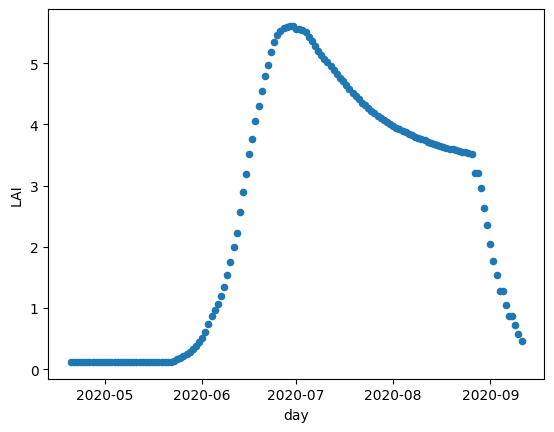

In [8]:
observed_data.plot.scatter("day", "LAI")

In [9]:
params.get("SPAN")

37.0

In [10]:
params.get("TDWI")

75.0

# Calibration procedure

## Iterative ensemble smoother

We will next run the calibration procedures against observed LAI data. In this case, we will perform history matching via [the iterative ensemble smoother package](https://iterative-ensemble-smoother.readthedocs.io/en/latest/index.html).

We begin by specifying our parameter distributions. We will calibrate 2 parameters:

- SPAN: Life span of leaves growing at 35C
- TDWI: Initial total seed tuber dry weight

Parameter ranges were taken from [Time-Dependent Sensitivity Analysis of Wofost-Potato for Temperate and Subtropical Environments (Lui et al., 2025)](https://www.sciencedirect.com/science/article/pii/S116103012500303X)

Note that we are using Normal distributions for our parameters, as the iterative ensemble smoother update step is parametric and assumes Gaussianity in the joint distribution of parameters and observations. More on that later...

In [11]:
parameter_spec = ParameterSpecification(
	parameters=[
		DistributionModel(
			name="TDWI",
			distribution_name="normal",
			distribution_args=[75, 10],
			data_type=ParameterDataType.CONTINUOUS,
		),
		DistributionModel(
			name="SPAN",
			distribution_name="normal",
			distribution_args=[37, 5],
			data_type=ParameterDataType.CONTINUOUS,
		),
	]
)

In [12]:
def history_matching_func(
	parameters: dict, simulation_id: str, observed_data: np.ndarray | None
) -> float | list[float]:
    p = copy.deepcopy(params)
    for k in parameters:
        p.set_override(k, parameters[k])
                
    wofost = Wofost72_PP(p, wdp, agro)
    wofost.run_till_terminate()
    simulated_data = pd.DataFrame(wofost.get_output()).LAI.values
    return simulated_data

The iterative ensemble smoother will thereafter create an ensemble of WOFOST simulations from the joint distribution of our parameter specifications. Each ensemble member is run through the model and compared to observations, and the ensemble is updated iteratively using a Kalman-like gain: 

$$
    \mathbf{m}^{(k+1)} = \mathbf{m}^{(k)} + \mathbf{C}_{md} (\mathbf{C}_{dd} + \mathbf{R})^{-1} (\mathbf{d}_{obs} - \mathbf{d}^{(k)})
$$

where:  
- $\mathbf{m}^{(k)}$ = ensemble of parameters at iteration $k$  
- $\mathbf{d}^{(k)}$ = simulated observations for ensemble  
- $\mathbf{d}_{obs}$ = actual observations  
- $\mathbf{C}_{md}$ = cross-covariance between parameters and simulated observations  
- $\mathbf{C}_{dd}$ = covariance of simulated observations  
- $\mathbf{R}$ = observation error covariance  
    
Ensemble members move toward regions that better match the data, and will eventually concentrate in plausible regions after several iterations. [More information on the iterative ensemble smoother can be found here](https://www.frontiersin.org/articles/10.3389/fams.2019.00047/full).

For demonstration purposes, we will use an ensemble size of **M** = 10 and 5 iterations.

SIES iteration 1/10
SIES iteration 2/10
SIES iteration 3/10
SIES iteration 4/10
SIES iteration 5/10
SIES iteration 6/10
SIES iteration 7/10
SIES iteration 8/10
SIES iteration 9/10
SIES iteration 10/10


/home/jbris/.cache/pypoetry/virtualenvs/calisim-examples-yfUJKvMn-py3.10/lib/python3.10/site-packages/calisim/base/calibration_base.py:427: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


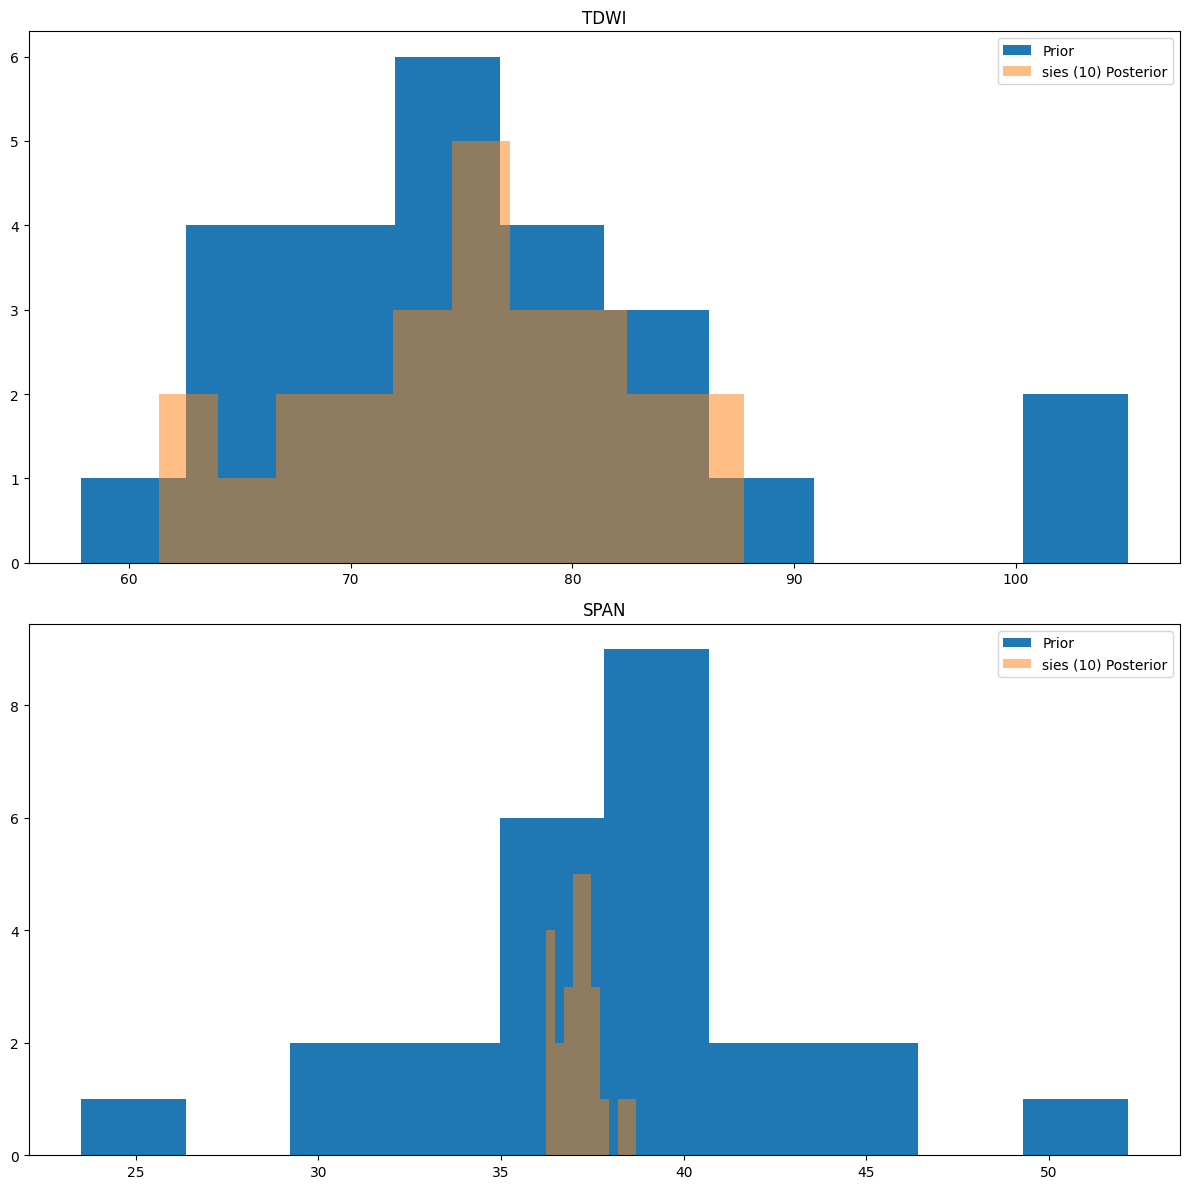

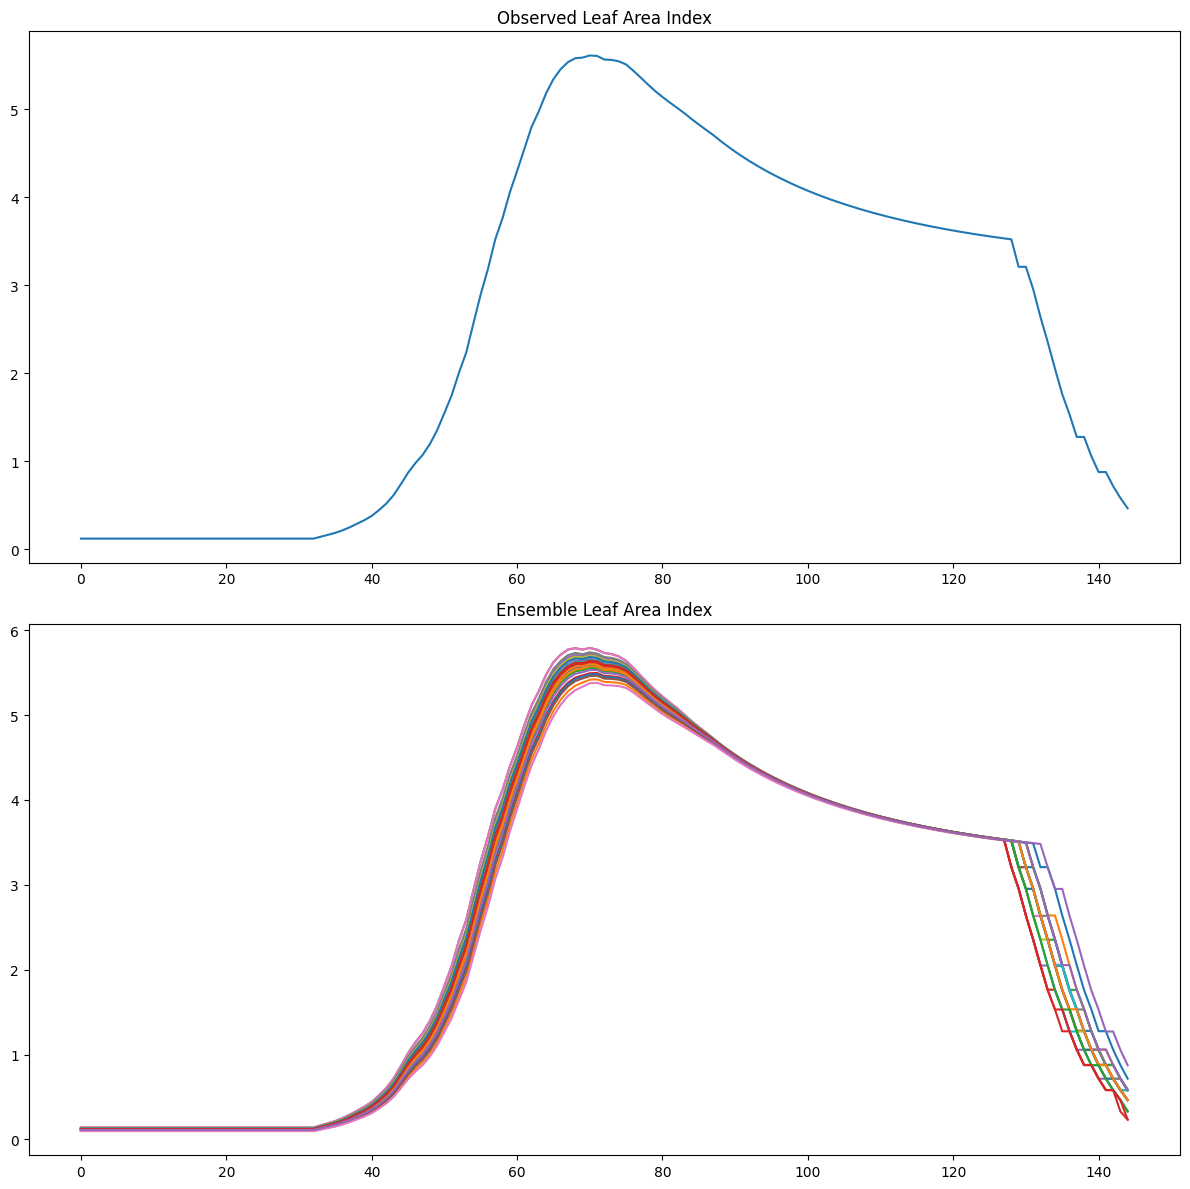

In [13]:
specification = HistoryMatchingMethodModel(
	experiment_name="ies_history_matching",
	parameter_spec=parameter_spec,
	observed_data=observed_data.LAI.values,
	method="sies",
	n_samples=25,
	n_iterations=10,
	output_labels=["Leaf Area Index"],
	verbose=True,
	batched=False,
	covariance=np.eye(observed_data.LAI.values.shape[0]),
	method_kwargs=dict(truncation=1.0),
)

calibrator = HistoryMatchingMethod(
	calibration_func=history_matching_func, specification=specification, engine="ies"
)

calibrator.specify().execute().analyze()

We can see the difference between our prior distribution (the parameter specification), and posterior distribution (the plausible distribution of parameter values post-history matching).

In the plot above, we can see the ensemble trajectories of LAI. The ensemble spread is appears to be relatively small, and our model seems to be well calibrated following the use of history matching.

In [14]:
hm_df = pd.DataFrame({
    "parameter_name": [ 
        model.name
        for model in calibrator.get_parameter_estimates().estimates
    ],
    "parameter_estimate": [ 
        model.estimate
        for model in calibrator.get_parameter_estimates().estimates
    ],
    "parameter_uncertainty": [ 
        model.uncertainty
        for model in calibrator.get_parameter_estimates().estimates
    ],
})
hm_df

,parameter_name,parameter_estimate,parameter_uncertainty
0,TDWI,75.413444,6.910772
1,SPAN,37.139726,0.591143


<Axes: xlabel='observed', ylabel='simulated'>

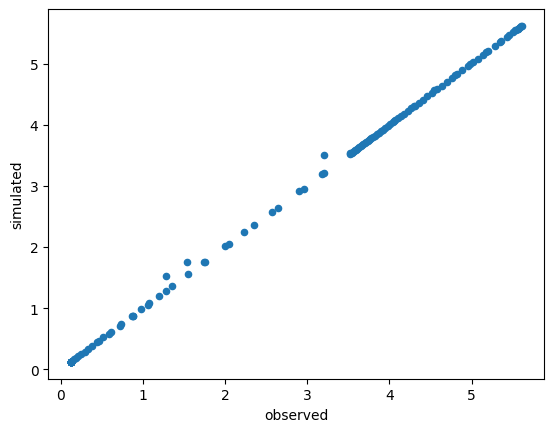

In [15]:
parameters = { 
    row["parameter_name"]: row["parameter_estimate"]
    for row in hm_df.to_dict("records")
}

p = copy.deepcopy(params)
for k in parameters:
    p.set_override(k, parameters[k])
        
wofost = Wofost72_PP(p, wdp, agro)
wofost.run_till_terminate()

pd.DataFrame({
    "observed": observed_data.LAI.values,
    "simulated": pd.DataFrame(wofost.get_output()).LAI.values
}).plot.scatter("observed", "simulated")

After calibration via history matching, the predictive accuracy of our WOFOST model is quite high. The model's behaviour more closely reflects that of reality.

## Ensemble smoother with multiple data assimilation 

One advantage of calisim is its modular nature. We can easily switch between different calibration packages and algorithms with minimal code changes. [Let's switch to using the pyESMDA package](https://pyesmda.readthedocs.io/en/stable/). 

This library uses the ensemble smoother with multiple data assimilation (ESMDA) algorithm. [More information on ESMDA can be found here](https://www.sciencedirect.com/science/article/abs/pii/S0098300412000994).

Assimilation # 1
Assimilation # 2
Assimilation # 3
Assimilation # 4
Assimilation # 5
Assimilation # 6
Assimilation # 7
Assimilation # 8
Assimilation # 9
Assimilation # 10


/home/jbris/.cache/pypoetry/virtualenvs/calisim-examples-yfUJKvMn-py3.10/lib/python3.10/site-packages/calisim/base/calibration_base.py:427: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/home/jbris/.cache/pypoetry/virtualenvs/calisim-examples-yfUJKvMn-py3.10/lib/python3.10/site-packages/calisim/base/calibration_base.py:427: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


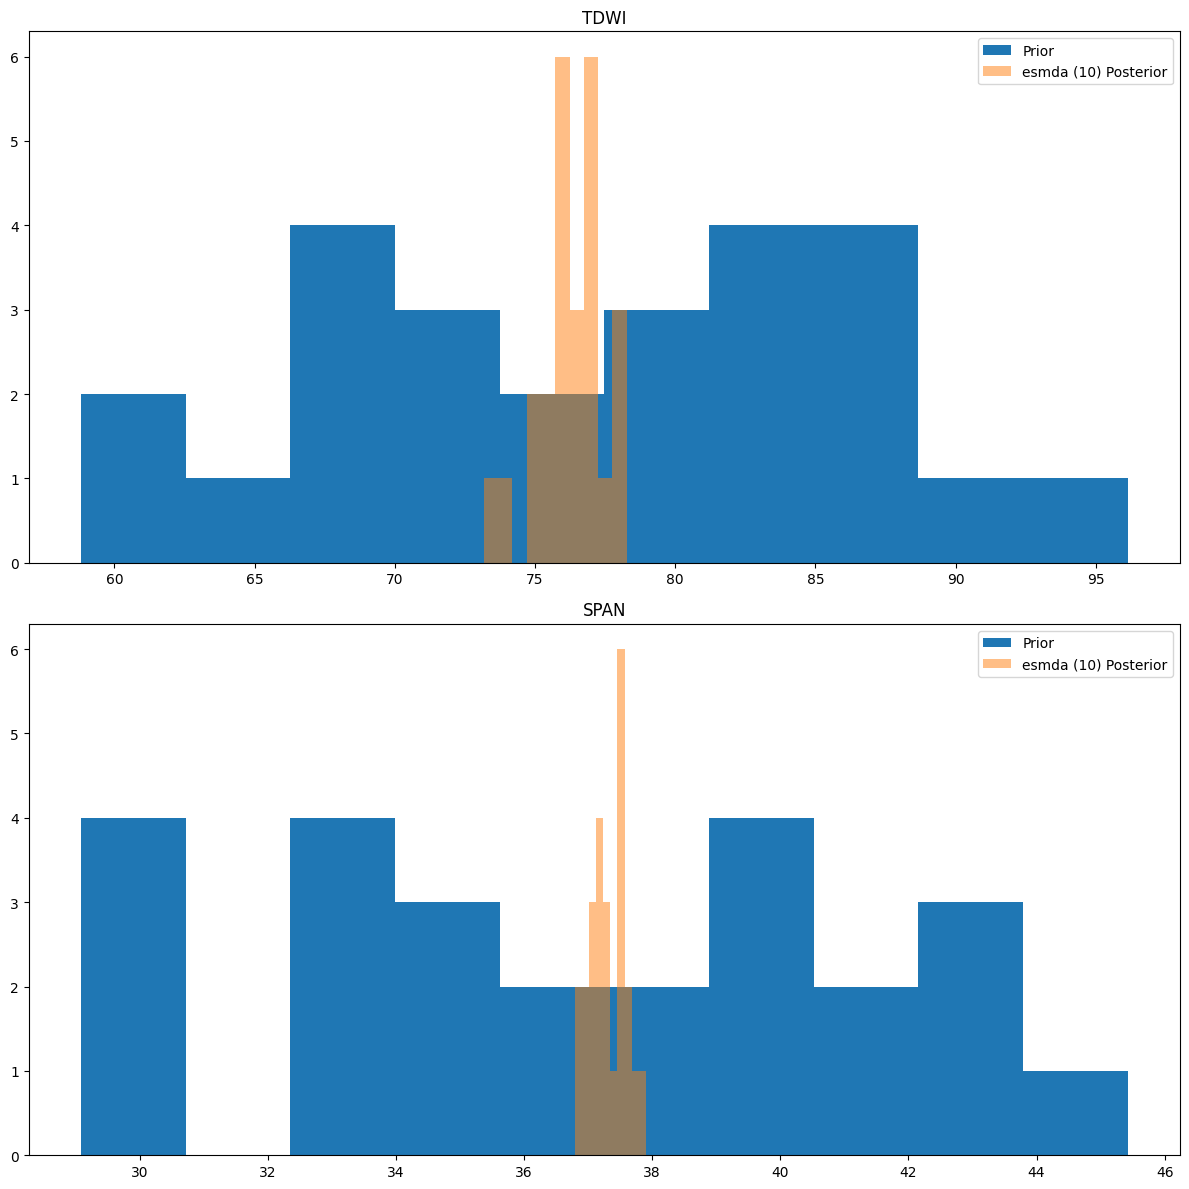

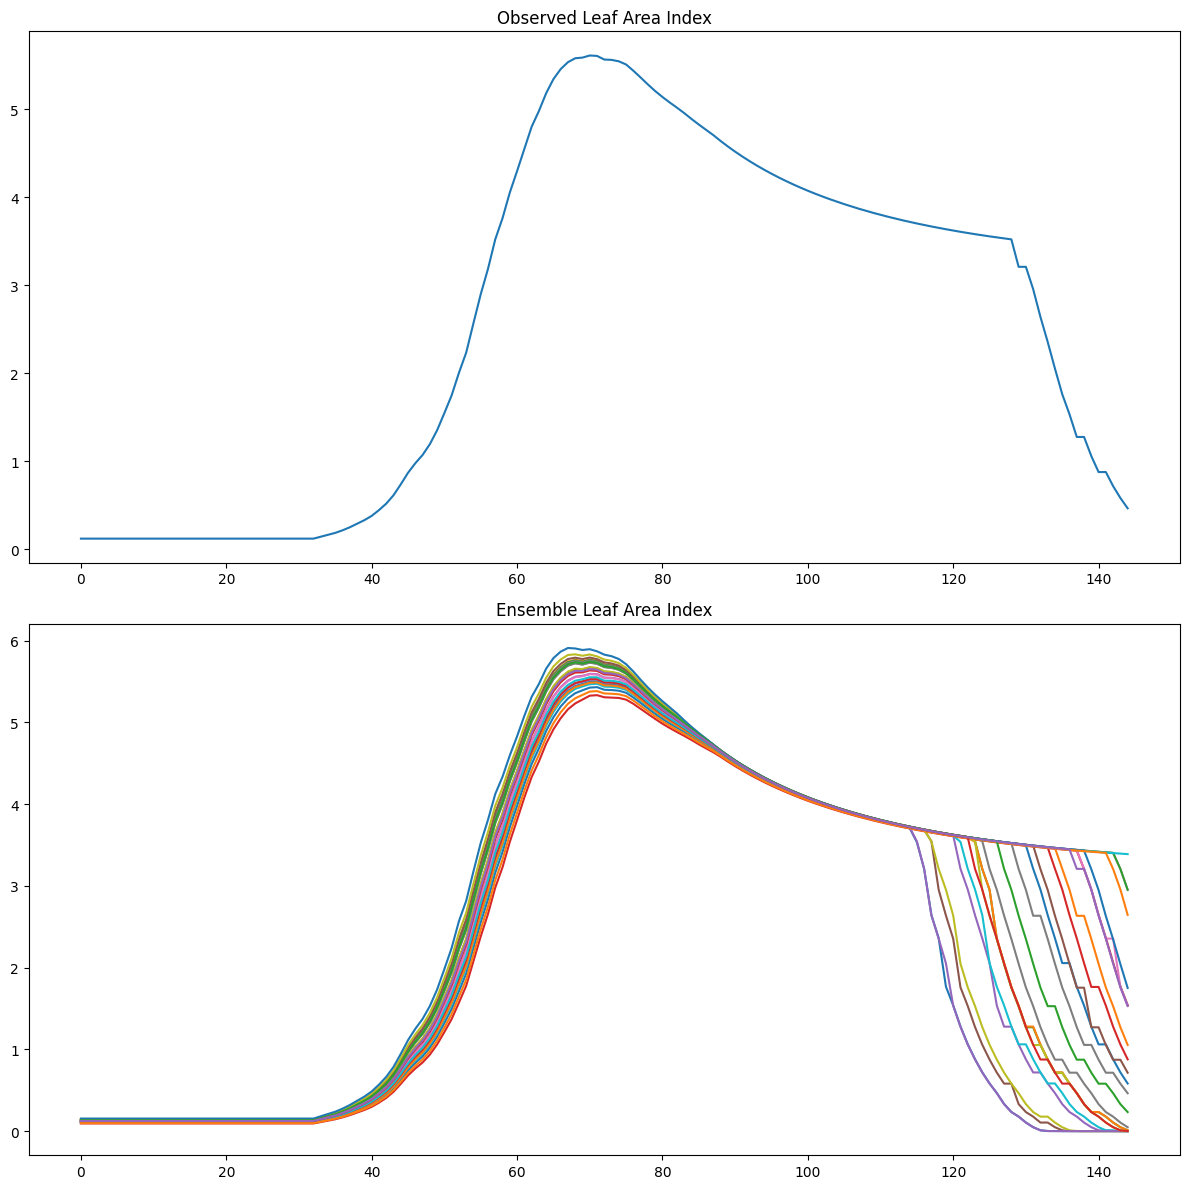

In [16]:
specification = HistoryMatchingMethodModel(
	experiment_name="pyesmda_history_matching",
	parameter_spec=parameter_spec,
	observed_data=observed_data.LAI.values,
	method="esmda",
	n_samples=25,
	n_iterations=10,
	output_labels=["Leaf Area Index"],
	verbose=True,
	batched=False,
	covariance=np.eye(observed_data.LAI.values.shape[0]),
	method_kwargs=dict(save_ensembles_history=True)
)

calibrator = HistoryMatchingMethod(
	calibration_func=history_matching_func, specification=specification, engine="pyesmda"
)

calibrator.specify().execute().analyze()

Hence, a secondary use for calisim is library and algorithm benchmarking, critique, and comparison.

In [17]:
hm_df = pd.DataFrame({
    "parameter_name": [ 
        model.name
        for model in calibrator.get_parameter_estimates().estimates
    ],
    "parameter_estimate": [ 
        model.estimate
        for model in calibrator.get_parameter_estimates().estimates
    ],
    "parameter_uncertainty": [ 
        model.uncertainty
        for model in calibrator.get_parameter_estimates().estimates
    ],
})
hm_df

,parameter_name,parameter_estimate,parameter_uncertainty
0,TDWI,76.298817,1.201643
1,SPAN,37.298377,0.284167


We see the probabilistic parameter estimates above for our 2 parameters, offering both point estimates and some measure of uncertainty. We can run WOFOST again using these calibrated estimates, and compare the simulated and observed LAI values.

<Axes: xlabel='observed', ylabel='simulated'>

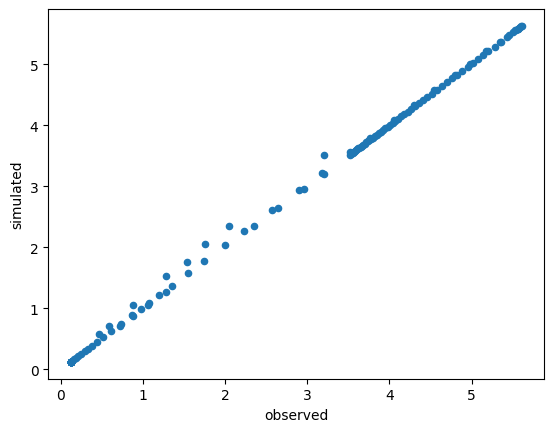

In [18]:
parameters = { 
    row["parameter_name"]: row["parameter_estimate"]
    for row in hm_df.to_dict("records")
}

p = copy.deepcopy(params)
for k in parameters:
    p.set_override(k, parameters[k])
        
wofost = Wofost72_PP(p, wdp, agro)
wofost.run_till_terminate()

pd.DataFrame({
    "observed": observed_data.LAI.values,
    "simulated": pd.DataFrame(wofost.get_output()).LAI.values
}).plot.scatter("observed", "simulated")

The predictive accuracy when using ESMDA is also pretty good.